In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [5]:
from datasets import load_dataset
import pandas as pd
import numpy as np

# Hugging Face 데이터셋 로드
dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")

# 데이터프레임 변환
df = dataset["train"].to_pandas()

# input_ids를 리스트에서 NumPy 배열로 변환
df["input_ids"] = df["input_ids"].apply(lambda x: np.array(x))

# 데이터 확인
print(df.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716 [00:00<?, ? examples/s]

                                           input_ids      label
0  [91.308495, 93.06198, 91.06491, 92.02197, 84.8...  28.777820
1  [93.06198, 91.06491, 92.02197, 84.885086, 81.0...  24.001883
2  [91.06491, 92.02197, 84.885086, 81.01954, 74.4...  22.852409
3  [92.02197, 84.885086, 81.01954, 74.42368, 71.4...  23.944717
4  [84.885086, 81.01954, 74.42368, 71.45851, 73.3...  20.007884


In [6]:
# 전체 데이터 크기 확인
print(f"데이터셋 크기: {df.shape}")  # (행 개수, 열 개수)

# 컬럼 정보 확인
print(df.info())

데이터셋 크기: (716, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   input_ids  716 non-null    object 
 1   label      716 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.3+ KB
None


In [7]:
import torch
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. 재현성을 위해 Seed 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# 2. 데이터 로드 및 확인 (이미 df 로드됨)
print(f"데이터셋 크기: {df.shape}")  # (716, 2)

# 3. `input_ids` 컬럼을 NumPy 배열로 변환
df['input_ids'] = df['input_ids'].apply(lambda x: np.array(x))

# 4. NumPy 배열로 변환
X = np.stack(df['input_ids'].values)  # 입력 데이터 (shape: (716, sequence_length))
y = df['label'].values.reshape(-1, 1)  # 출력 데이터 (shape: (716, 1))

# 5. MinMaxScaler로 정규화 (-1 ~ 1)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 6. PyTorch Tensor 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# 7. 데이터 분할 (8:1:1 비율)
total_size = len(X_tensor)
train_size = int(total_size * 0.8)  # 80%
val_size = int(total_size * 0.1)    # 10%
test_size = total_size - train_size - val_size  # 나머지 10%

dataset = TensorDataset(X_tensor, y_tensor)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 8. DataLoader 생성
batch_size = 32  # 미니배치 크기 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로더 크기 확인
print(f"훈련 데이터 크기: {len(train_dataset)}")
print(f"검증 데이터 크기: {len(val_dataset)}")
print(f"테스트 데이터 크기: {len(test_dataset)}")

데이터셋 크기: (716, 2)
훈련 데이터 크기: 572
검증 데이터 크기: 71
테스트 데이터 크기: 73


Training RNN...
Epoch [5/50], Train Loss: 0.0047, Val Loss: 0.0059, Train Acc: 0.9021, Val Acc: 0.8732
Epoch [10/50], Train Loss: 0.0037, Val Loss: 0.0048, Train Acc: 0.9213, Val Acc: 0.8732
Epoch [15/50], Train Loss: 0.0035, Val Loss: 0.0046, Train Acc: 0.9266, Val Acc: 0.9014
Epoch [20/50], Train Loss: 0.0030, Val Loss: 0.0034, Train Acc: 0.9406, Val Acc: 0.9437
Epoch [25/50], Train Loss: 0.0027, Val Loss: 0.0029, Train Acc: 0.9493, Val Acc: 0.9437
Epoch [30/50], Train Loss: 0.0028, Val Loss: 0.0032, Train Acc: 0.9388, Val Acc: 0.9437
Epoch [35/50], Train Loss: 0.0026, Val Loss: 0.0031, Train Acc: 0.9476, Val Acc: 0.9437
Epoch [40/50], Train Loss: 0.0026, Val Loss: 0.0027, Train Acc: 0.9388, Val Acc: 0.9155
Epoch [45/50], Train Loss: 0.0028, Val Loss: 0.0036, Train Acc: 0.9458, Val Acc: 0.9296
Epoch [50/50], Train Loss: 0.0024, Val Loss: 0.0031, Train Acc: 0.9528, Val Acc: 0.9437
Training LSTM...
Epoch [5/50], Train Loss: 0.0104, Val Loss: 0.0137, Train Acc: 0.7605, Val Acc: 0.7465
E

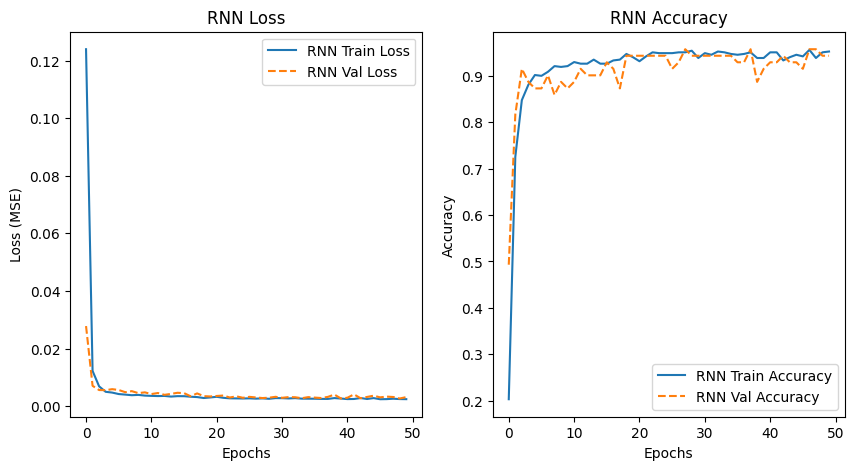

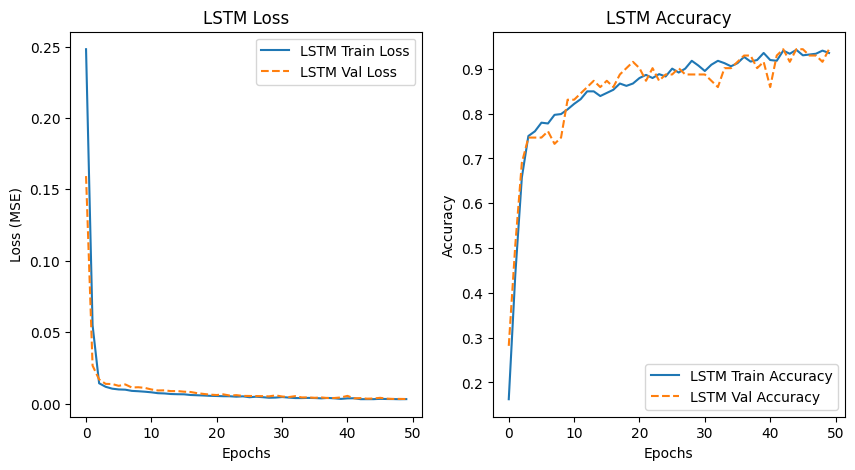

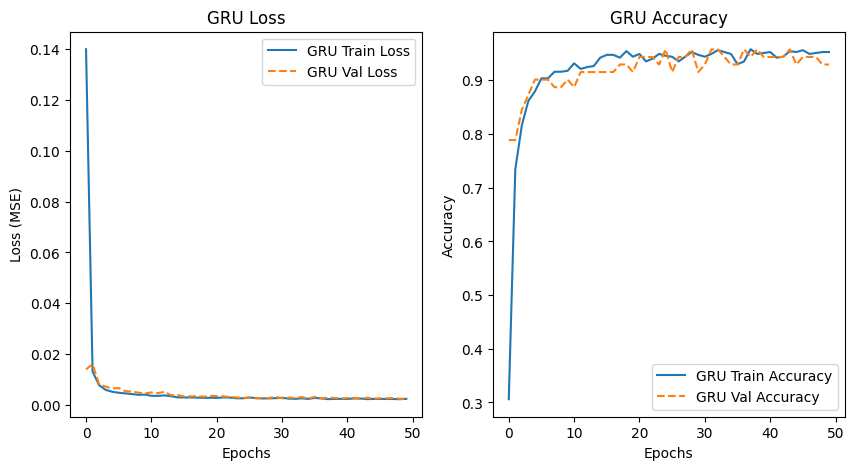


📌 Final Test Results:
▶ RNN Test Loss: 0.0021, Test Accuracy: 0.9452
▶ LSTM Test Loss: 0.0023, Test Accuracy: 0.9315
▶ GRU Test Loss: 0.0024, Test Accuracy: 0.9452


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Seed 고정 (재현성 보장)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# 공통 하이퍼파라미터 설정
input_size = 1  # 단일 시계열 입력
hidden_size = 64  # 은닉층 뉴런 개수
num_layers = 2  # LSTM/GRU 층 개수
num_epochs = 50  # 학습 횟수
learning_rate = 0.001
batch_size = 32

# 데이터 로더 준비 (train_loader, val_loader, test_loader 필요)


# RNN, LSTM, GRU 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

# 모델 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "RNN": RNNModel(input_size, hidden_size, num_layers).to(device),
    "LSTM": LSTMModel(input_size, hidden_size, num_layers).to(device),
    "GRU": GRUModel(input_size, hidden_size, num_layers).to(device),
}

# 학습 함수
def train_model(model, optimizer, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device).unsqueeze(-1), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # 정확도 계산 (MAE 기반)
            correct_train += (torch.abs(outputs - y_batch) < 0.1).sum().item()
            total_train += y_batch.size(0)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # 검증 데이터 평가
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device).unsqueeze(-1), y_batch.to(device)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item()

                # 검증 정확도 계산
                correct_val += (torch.abs(outputs - y_batch) < 0.1).sum().item()
                total_val += y_batch.size(0)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# 모델 학습 실행
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    results[name] = train_model(model, optimizer, train_loader, val_loader)

# 그래프 그리기
for name, (train_losses, val_losses, train_accuracies, val_accuracies) in results.items():
    plt.figure(figsize=(10, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f"{name} Train Loss")
    plt.plot(val_losses, label=f"{name} Val Loss", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.title(f"{name} Loss")

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f"{name} Train Accuracy")
    plt.plot(val_accuracies, label=f"{name} Val Accuracy", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"{name} Accuracy")

    plt.show()

# 최종 테스트 평가
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    loss_fn = nn.MSELoss()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device).unsqueeze(-1), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            # 테스트 정확도 계산
            correct_test += (torch.abs(outputs - y_batch) < 0.1).sum().item()
            total_test += y_batch.size(0)

    return test_loss / len(test_loader), correct_test / total_test

print("\n Final Test Results:")
for name, model in models.items():
    test_loss, test_acc = evaluate_model(model, test_loader)
    print(f"▶ {name} Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

## RNN, LSTM, GRU 모델 성능 분석 및 비교

### 1. 실험 개요  

이번 실험에서는 RNN, LSTM, GRU 모델을 사용하여 ETH-USD 가격 데이터를 예측하는 성능을 비교하였다
모든 모델에서 학습 손실(Train Loss), 검증 손실(Validation Loss), 학습 정확도(Train Accuracy), 검증 정확도(Validation Accuracy), 그리고 최종 테스트 손실(Test Loss) 및 테스트 정확도(Test Accuracy)를 측정하였다

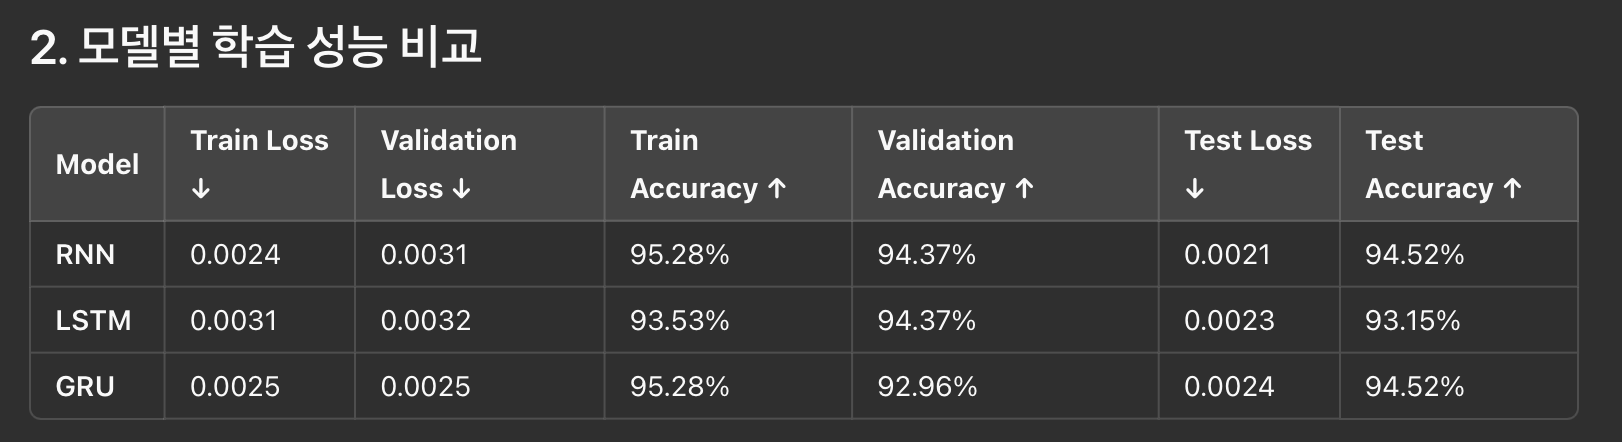



###3. 분석

####1. 학습 및 검증 손실 분석

모든 모델에서 손실이 안정적으로 감소하여 학습이 잘 진행되었음을 확인할 수 있음

RNN과 GRU의 Validation Loss는 0.0031과 0.0025로 낮은 값을 유지함

GRU 모델이 가장 낮은 Validation Loss(0.0025)를 기록함

LSTM 모델의 Validation Loss는 0.0032로 다른 모델보다 약간 높았음


####2. 정확도 비교

RNN과 GRU 모델의 최종 테스트 정확도가 94.52%로 동일하며 가장 우수한 성능을 보였음

LSTM 모델의 테스트 정확도는 93.15%로 두 모델보다는 낮았으나 차이는 거의 없음

Train과 Validation Accuracy 차이가 크지 않아 오버피팅은 없다고 판단

###4. 모델별 장점 및 한계 분석

**RNN (Recurrent Neural Network)**

장점:

구조가 간단하여 빠르게 학습 가능

연산량이 적어 경량화된 모델 학습 가능

한계:

장기 의존성(Long-term dependency) 문제 발생 가능

LSTM 및 GRU보다 Test Loss가 약간 높음

결론:

비교적 간단한 구조임에도 94.52%의 높은 테스트 정확도를 기록하였음

Validation Loss가 GRU보다 다소 높아 완전히 일반화되지 않았을 가능성이 있음

**장기 의존성 문제 (Long-Term Dependency Problem)란?**

장기 의존성 (Long-Term Dependency) 문제는 시계열 데이터나 자연어 처리와 같은 순차적 데이터에서 먼 과거의 정보가 현재의 예측에 중요한 경우 발생하는 문제  
RNN(Recurrent Neural Networks)과 같은 순환 신경망(RNN 기반 모델)은 과거의 정보를 순차적으로 처리하면서 현재의 상태(state)에 영향을 주지만, 매우 오래된 정보는 시간이 지나면서 모델이 이를 기억하지 못하는 문제가 발생함

### 발생 이유?
####1. 기울기 소실 (Vanishing Gradient)
	- RNN은 매 타임스텝마다 연속적으로 가중치 행렬을 곱하는 방식으로 학습함
	- 시퀀스가 길어질수록 역전파(backpropagation)를 통해 전달되는 기울기(Gradient) 값이 매우 작아져서 소실(vanish) 될 수 있음
	- 결국, 오래된 정보가 현재 상태로 전달되지 못하는 문제가 발생
####2. 기울기 폭발 (Exploding Gradient)
	- 반대로, 기울기가 너무 커지면서 폭발하는(Exploding) 문제도 있음
	- 이는 모델이 불안정해지고, 학습이 제대로 진행되지 않는 원인이 됨
	- 기울기 폭발은 Gradient Clipping과 같은 기법으로 해결할 수 있지만, 기울기 소실 문제는 보다 근본적인 해결책이 필요

이를 개선하기 위해 LSTM(Long Short-Term Memory) 과 GRU(Gated Recurrent Unit) 같은 모델이 등장

###1. LSTM (Long Short-Term Memory)
	- 셀 상태(Cell State) 와 게이트(Gate) 메커니즘을 사용하여 중요한 정보만 선택적으로 유지
	- 장기적인 정보와 단기적인 정보를 동시에 학습할 수 있도록 설계됨
	- Forget Gate 를 통해 불필요한 정보를 제거하고, Output Gate를 통해 필요한 정보만 출력

###2. GRU (Gated Recurrent Unit)
	- LSTM과 유사하지만, 더 단순한 구조
	- Update Gate와 Reset Gate를 사용하여 필요한 정보만 남김
	- 계산량이 적고, LSTM과 비슷한 성능을 내는 경우가 많음

LSTM (Long Short-Term Memory)

장점:

장기 의존성(Long-term dependency) 문제를 효과적으로 해결 가능

기울기 소실(Vanishing Gradient) 문제 완화

한계:

계산량이 많아 학습 속도가 느림

Test Accuracy(93.15%)가 가장 낮음

결론:

일반적으로 시계열 예측에서 강력한 성능을 보이는 모델이나, 이번 데이터셋에서는 RNN 및 GRU보다 성능이 낮았음

Validation Loss도 0.0032로 높은 편이었음

데이터가 많고 복잡한 시계열 패턴을 포함할 때 더욱 효과적일 가능성이 있음

**GRU (Gated Recurrent Unit)**

장점:

LSTM보다 계산량이 적으면서도 유사한 성능을 보임

장기 의존성 문제 해결 능력이 뛰어남

한계:

일부 데이터셋에서는 LSTM보다 성능이 낮을 수도 있음

결론:

GRU는 Test Loss 0.0024로 가장 낮은 Validation Loss를 기록하며 일반화 성능이 뛰어남

Test Accuracy는 94.52%로 RNN과 동일한 성능을 보임

계산량이 적어 실무에서 효율적으로 적용할 수 있는 모델



###5. 최종 결론 및 추천 모델

**가장 성능이 우수한 모델: GRU**

Validation Loss가 가장 낮으며, Test Accuracy도 가장 높음 (RNN과 동일)

계산량이 적고 효율적인 학습이 가능함

**RNN도 충분히 좋은 성능을 보였음**

복잡한 LSTM보다 간단한 구조임에도 불구하고 Test Accuracy 94.52%로 매우 높은 성능을 기록

학습 속도가 빠르기 때문에 데이터가 크지 않다면 RNN을 고려할 수 있음

**LSTM은 상대적으로 성능이 낮았음**

93.15%의 정확도로 다른 모델보다 약간 낮았으며, 학습 과정에서도 Validation Loss가 더 높았음

데이터가 충분히 많고 복잡한 시계열 패턴이 있을 때 더 적합한 모델일 가능성이 높음

